In [1]:
from math import sqrt
from numpy import concatenate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

%matplotlib inline

C:\Users\drllc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [16]:
# load data
def parse(x):
    return pd.datetime.strptime(x, '%Y %m %d %H')

In [17]:
dataset = pd.read_csv('Beijing_Test_Data.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

# drop the first 24 hours
dataset = dataset[24:]

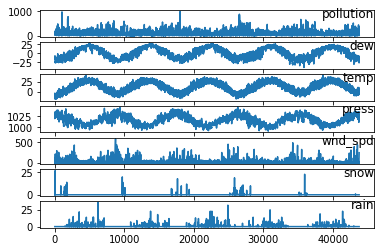

In [18]:
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [19]:
# integer encode wind direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
n_hours = 3
n_features = 8

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
reframed2 = series_to_supervised(scaled, n_hours, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-1,-2,-3,-4,-5,-6,-7]], axis=1, inplace=True)

In [29]:
reframed2.to_csv('reframed.csv', sep='\t')

In [20]:
# split into train and test sets
values = reframed2.values
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours,:]
test = values[n_train_hours:,:]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

# split into input and outputs
#train_X, train_y = train[:, :-1], train[:, -1]
#test_X, test_y = test[:, :-1], test[:, -1]
#print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
#test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 24) 26280 (26280,)
(26280, 24) (26280,) (17517, 24) (17517,)


In [31]:
trial = pd.DataFrame(train_X)
trial.to_csv('trial.csv', sep='\t')

trial2 = pd.DataFrame(train_y)
trial2.to_csv('trial2.csv', sep='\t')

In [35]:
# design network
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(24,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='mae', optimizer='adadelta', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               12800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 275,969
Trainable params: 275,969
Non-trainable params: 0
_________________________________________________________________


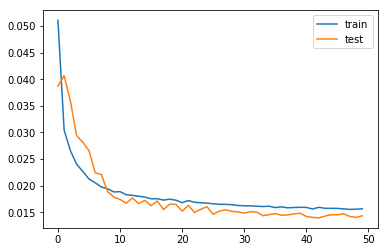

In [36]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [37]:
score = model.evaluate(test_X,test_y,verbose=0)

print('Test Loss: ',score[0])
print('Test Accuracy: ',score[1])

Test Loss:  0.014341574425712801
Test Accuracy:  0.010332819546726038


In [57]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 27.188


In [173]:
test_X2 = test_X.reshape((test_X.shape[0], n_hours*n_features))
test_X2[:,-7:].shape

(17517, 7)

In [49]:
a = np.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12]]) 

In [50]:
print(a)
print(a.shape)

[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]
(4, 3)


In [52]:
a[:,-2:]

array([[ 2,  3],
       [ 5,  6],
       [ 8,  9],
       [11, 12]])

In [184]:
inv_yhat = concatenate((yhat, test_X2[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

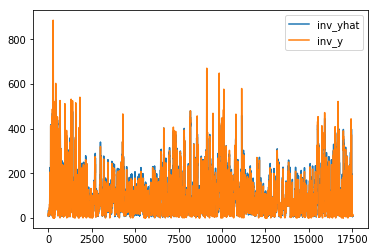

In [78]:
#plt.plot(test_y, label='test')
plt.plot(inv_yhat, label='inv_yhat')
plt.plot(inv_y, label='inv_y')
plt.legend()

In [79]:
type(train)

numpy.ndarray